# Notebook to merge Benifly tracking results with current pipeline

## Imports

In [139]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
import os 
import glob
import pickle
# import pywt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.spatial.distance import cdist
from scipy.stats import median_abs_deviation
from scipy.interpolate import UnivariateSpline

from sklearn.cluster import KMeans

# from matplotlib import rcParams
from mosquito.process_abf import (load_processed_data, cluster_spikes, save_processed_data, detect_spikes, estimate_spike_rate, 
                                   detrend_emg, filter_emg)
from mosquito.util import set_plot_params, my_adjust_axes, my_add_scalebar, idx_by_thresh, hampel
from mosquito.get_wing_kinematics import load_video_data, fetch_benifly_data, align_kinematics_to_cam, incorporate_benifly_tracking


## Params

In [149]:
plt.style.use('default')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize for x tick labels
plt.rc('ytick', labelsize=14)    # fontsize for y tick labels

plot_type = 'poster'  # 'paper' or 'powerpoint' or 'poster
plot_params = set_plot_params(plot_type=plot_type)

## Load data

In [142]:
# file info
data_folder = 57
axo_num = 0


In [143]:
# data = incorporate_benifly_tracking(data_folder, axo_num)


In [144]:
# # first let's see if we can get tracking data
# track_data = fetch_benifly_data(data_folder, axo_num)
# track_data

In [145]:
# fig, ax = plt.subplots(figsize=(12,3))

# ax.plot(track_data['LeftWing'])

In [146]:
# also grab data from axoscope (need 'cam' signal)
data = load_processed_data(data_folder, axo_num)  # , data_suffix='spikes')

for key in data.keys():
    print(key)
    

sampling_freq
filepath
units
header
time
emg
cam
mic
odor
species
muscle_type
filename
mic_filt
mic_phase
wbf_mean
wbf
flying_idx
emg_filt
spikes
spike_t
spike_idx
spike_rate
cluster_labels
params
filepath_load
wing


In [147]:
# read out some fields
cam = data['cam']
t = data['time']
spike_rate = data['spike_rate']
wbf = data['wbf']
left_amp_interp = data['wing']['left_amp']
left_amp_raw = data['wing']['left_amp_raw']

fs = data['sampling_freq']

In [133]:
# # determine the sync_output_rate for alignment
# _, metadata = load_video_data(data_folder, axo_num, just_return_fps_flag=True)
# vid_fps = metadata['record_fps']

# cam_idx = idx_by_thresh(cam)
# cam_idx = np.asarray([idx[0] for idx in cam_idx])
# cam_freq = fs/np.mean(np.diff(cam_idx))

# # use these two to get sync_output_rate
# # NB: possible values are 0.5, 1, 2, 4, so we need a round step
# sync_output_rate = round(10 * (cam_freq / vid_fps)) / 10.0
# sync_output_rate

In [134]:
# # try to align these values to camera signal 
# left_amp, align_idx_left = align_kinematics_to_cam(track_data['LeftWing'], data['cam'], sync_output_rate=sync_output_rate)
# right_amp, align_idx_right = align_kinematics_to_cam(track_data['RightWing'], data['cam'], sync_output_rate=sync_output_rate)

In [135]:
# # interpolate wing kinematics
# left_amp_interp = left_amp.copy()
# smooth_factor = 1

# align_nan_idx = np.isnan(left_amp[align_idx_left])
# f_amp = UnivariateSpline(t[align_idx_left][~align_nan_idx],
#                          left_amp[align_idx_left][~align_nan_idx],
#                          s=smooth_factor,
#                          ext=3)  # ext=3 means we extrapolate using boundary vals

# # to preserve nans outside video region, only apply interpolant to small region
# interp_region = np.arange(align_idx_left[~align_nan_idx][0],
#                           align_idx_left[~align_nan_idx][-1])

# left_amp_interp[interp_region] = f_amp(t[interp_region])

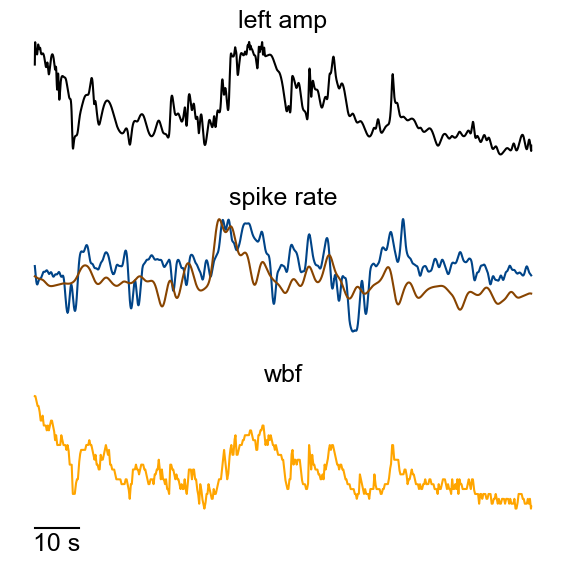

In [156]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(6,6), sharex=True)

tracking_window = ~np.isnan(left_amp_interp)
tmin = t[tracking_window][0]
tmax = t[tracking_window][-1]
tmask = (t >= tmin) & (t <= tmax)

# ax.plot(data['wing']['left_lead_raw'], '.', alpha=0.2)
# ax.plot(left_amp, '.', alpha=0.2)
# ax.plot(right_amp, '.', alpha=0.2)
ax0.plot(t[tmask] - t[tmask][0], left_amp_interp[tmask], 'k')
ax0.set_title('left amp')
ax0 = my_adjust_axes(ax0, keep_spines=['none'])

# if type(spike_rate) is list:
#     spike_rate_data = spike_rate[0]
# else:
#     spike_rate_data = spike_rate
spike_rate_colors = ['#004488', '#884400']
for color, spike_rate_data in zip(spike_rate_colors, spike_rate):
    ax1.plot(t[tmask] - t[tmask][0], spike_rate_data[tmask], color=color)
ax1.set_title('spike rate')
ax1 = my_adjust_axes(ax1, keep_spines=['none'])

ax2.plot(t[tmask] - t[tmask][0], wbf[tmask], color='orange')
ax2.set_title('wbf')
ax2 = my_adjust_axes(ax2, keep_spines=['bottom'])

my_add_scalebar(ax2, scalebar_bounds=[0, 10], units='s')

fig.tight_layout()

save_path = '/media/sam/SamData/Dropbox/Misc Presentations/Dickinson Group Meeting 10-23-2024/ifm_recordings/tracking_data.png'
fig.savefig(save_path)

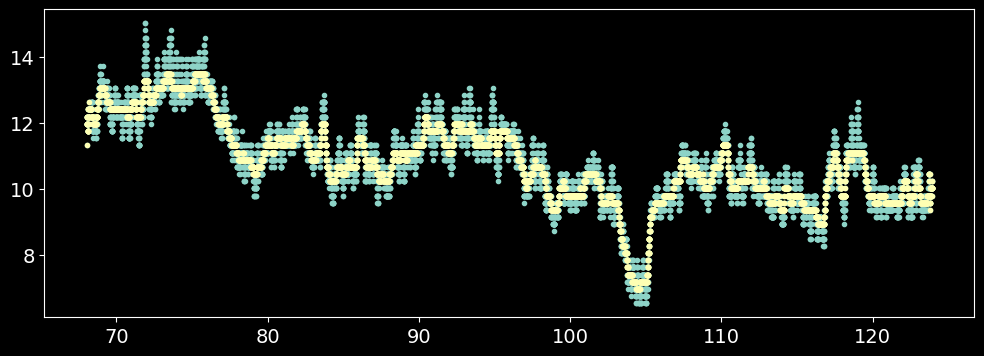

In [126]:
# try filtering wing kinematics
hampel_k = 101  # 201  # 21
hampel_t0 = 0.01

signal_raw = left_amp_raw
signal_filt = signal_raw.copy()
nan_idx = np.isnan(signal_filt)
# nan_idx |= (signal_filt < -np.pi/4)

signal_filt[~nan_idx], outlier_idx = hampel(signal_filt[~nan_idx], k=hampel_k, t0=hampel_t0)  # k=21
outlier_idx = np.where(~nan_idx)[0][outlier_idx]

# try to interpolate
signal_interp = np.interp(t, t[~nan_idx], signal_filt[~nan_idx])

# visualize 
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(t, np.rad2deg(signal_raw), '.')
ax.plot(t, np.rad2deg(signal_filt), '.')